In [398]:
import warnings
warnings.filterwarnings('ignore')

In [399]:
from imblearn.ensemble import BalancedRandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [400]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [401]:
Position_Player_df = pd.read_csv('Combined CSV\PositionPlayers_Complete.csv')

In [402]:
Position_Player_df.shape

(10506, 45)

In [403]:
Position_Player_df.columns

Index(['playerID', 'nameFirst', 'nameLast', 'weight', 'height', 'bats_L',
       'bats_R', 'throws_L', 'throws_R', 'Seasons', 'Games', 'At_Bats', 'Runs',
       'Hits', 'Doubles', 'Triples', 'Homeruns', 'RBIs', 'Stolen_Bases',
       'Walks', 'Intentional_Walks', 'Strike_Outs', 'Hit_by_Pitch', 'Sac_Hits',
       'Sac_Flys', 'Double_Plays', 'finalGame', 'Retired_Years', 'inducted',
       'yearID', 'Total_Games', 'Games_Started', 'Pitcher', 'Catcher',
       'FirstBase', 'SecondBase', 'ThirdBase', 'ShortStop', 'LeftField',
       'CenterField', 'RightField', 'Outfield', 'DH', 'Primary_Position',
       'Hall_Eligible'],
      dtype='object')

In [404]:
Position_Player_df.head()

,playerID,nameFirst,nameLast,weight,height,bats_L,bats_R,throws_L,throws_R,Seasons,...,SecondBase,ThirdBase,ShortStop,LeftField,CenterField,RightField,Outfield,DH,Primary_Position,Hall_Eligible
0,aaronha01,Hank,Aaron,180.0,72.0,0,1,0,1,23,...,0.013038,0.002122,0.000000,0.095512,0.093390,0.659187,0.836871,0.060946,Outfield,1
1,aaronto01,Tommie,Aaron,190.0,75.0,0,1,0,1,7,...,0.016018,0.022883,0.000000,0.308924,0.002288,0.004577,0.313501,0.000000,FirstBase,0
2,abadan01,Andy,Abad,184.0,73.0,1,0,1,0,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000,FirstBase,0
3,abadijo01,John,Abadie,192.0,72.0,0,1,0,1,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,FirstBase,0
4,abbated01,Ed,Abbaticchio,170.0,71.0,0,1,0,1,11,...,0.490058,0.023392,0.453801,0.000000,0.002339,0.001170,0.003509,0.000000,SecondBase,1


In [405]:
Position_Player_train_model = Position_Player_df[Position_Player_df['Hall_Eligible']==1]
Position_Player_train_model.head()

,playerID,nameFirst,nameLast,weight,height,bats_L,bats_R,throws_L,throws_R,Seasons,...,SecondBase,ThirdBase,ShortStop,LeftField,CenterField,RightField,Outfield,DH,Primary_Position,Hall_Eligible
0,aaronha01,Hank,Aaron,180.0,72.0,0,1,0,1,23,...,0.013038,0.002122,0.000000,0.095512,0.093390,0.659187,0.836871,0.060946,Outfield,1
4,abbated01,Ed,Abbaticchio,170.0,71.0,0,1,0,1,11,...,0.490058,0.023392,0.453801,0.000000,0.002339,0.001170,0.003509,0.000000,SecondBase,1
8,abbotku01,Kurt,Abbott,180.0,71.0,0,1,0,1,11,...,0.246439,0.061254,0.497151,0.045584,0.005698,0.011396,0.061254,0.008547,ShortStop,1
15,abramca01,Cal,Abrams,185.0,72.0,1,0,1,0,12,...,0.000000,0.000000,0.000000,0.167549,0.176367,0.477954,0.776014,0.000000,Outfield,1
16,abreubo01,Bobby,Abreu,220.0,72.0,1,0,0,1,22,...,0.000000,0.000000,0.000000,0.058557,0.008660,0.820619,0.881649,0.066392,Outfield,1


In [406]:
scale_pos_weight = (Position_Player_train_model.inducted.value_counts()[0])/Position_Player_train_model.inducted.value_counts()[1]
print(scale_pos_weight)

15.210191082802547


In [407]:
# Getting data ready for machine learning
data = Position_Player_train_model.drop(['inducted', 
                                  'playerID', 
                                  'nameFirst', 
                                  'nameLast', 
                                  'finalGame', 
                                  'yearID',
                                  'Primary_Position',
                                  'Hall_Eligible'], axis=1)
data.fillna(0, inplace=True)
target = Position_Player_train_model['inducted']
target.fillna(0, inplace=True)
feature_names = data.columns

In [408]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [409]:
len(X_test)

637

In [410]:
#CLF = Classifier
clf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
clf = clf.fit(X_train_scaled, y_train)
clf.score(X_test_scaled, y_test)

0.8838304552590267

In [411]:
y_predicted = clf.predict(X_test_scaled)
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.metrics import classification_report_imbalanced
print(confusion_matrix(y_test, y_predicted))

predictions_df = pd.concat([pd.DataFrame(X_test_scaled),              
                            pd.DataFrame(dict(predicted= y_predicted,actual=y_test
                            )).reset_index(drop=True)], axis=1)

[[525  73]
 [  1  38]]


In [412]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_predicted))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.88      0.97      0.93      0.92      0.85       598
          1       0.34      0.97      0.88      0.51      0.92      0.86        39

avg / total       0.96      0.88      0.97      0.91      0.92      0.85       637



In [413]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_predicted) 

0.9261426978818283

In [414]:
# List the features sorted in descending order by feature importance
sorted(zip(clf.feature_importances_, data.columns), reverse=True)

[(0.1356805553950914, 'RBIs'),
 (0.12081400576157915, 'Hits'),
 (0.09969822741173245, 'Runs'),
 (0.08626270782509667, 'At_Bats'),
 (0.0662839731510912, 'Total_Games'),
 (0.06600611702712983, 'Doubles'),
 (0.06146691390840423, 'Games'),
 (0.056121565194252376, 'Walks'),
 (0.0324881254899708, 'Triples'),
 (0.03067906309280309, 'Games_Started'),
 (0.028529556404944482, 'Retired_Years'),
 (0.02356021652549601, 'Hit_by_Pitch'),
 (0.016871415681282427, 'Stolen_Bases'),
 (0.01670100630903571, 'Sac_Flys'),
 (0.01648650264154889, 'Seasons'),
 (0.015647408827684093, 'Sac_Hits'),
 (0.013872259517066207, 'Strike_Outs'),
 (0.013360746320866028, 'Double_Plays'),
 (0.012562675747931549, 'Intentional_Walks'),
 (0.009638449707912947, 'Homeruns'),
 (0.00826124482025766, 'height'),
 (0.007948467121688674, 'Outfield'),
 (0.007891240100142293, 'LeftField'),
 (0.007597610828345199, 'FirstBase'),
 (0.007264990772095899, 'RightField'),
 (0.006861464651195357, 'weight'),
 (0.0057817977065267555, 'ThirdBase'),


<BarContainer object of 37 artists>

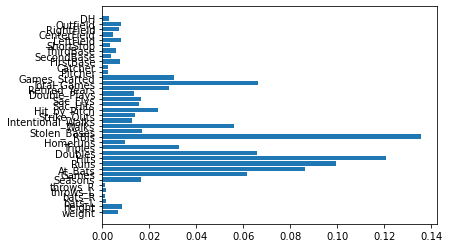

In [415]:
plt.barh(feature_names,clf.feature_importances_)

In [416]:
predictions_df

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,predicted,actual
0,-0.687935,-0.762919,1.500142,-1.205173,-0.385624,0.389202,0.047816,1.775483,1.982616,2.053922,...,-0.439544,-0.468612,-0.433741,-0.360659,3.672978,-0.439346,1.628617,-0.343150,1,1
1,-0.792241,-2.088475,-0.666604,0.829756,-0.385624,0.389202,0.551867,0.984215,1.391951,2.668048,...,-0.403658,-0.451074,-0.387346,1.053822,1.308413,0.685063,1.648160,-0.343150,1,1
2,0.459431,0.562636,-0.666604,0.829756,-0.385624,0.389202,-0.960285,-1.398340,-1.309635,-1.199359,...,-0.443496,-0.468612,-0.433741,-0.577104,-0.481891,-0.544261,-0.834139,-0.343150,0,0
3,0.459431,1.446340,-0.666604,0.829756,-0.385624,0.389202,-0.456234,0.431028,0.019249,-0.074343,...,-0.443496,-0.232784,-0.433741,-0.170741,0.704451,0.899981,0.737135,-0.343150,0,0
4,0.094360,0.120784,-0.666604,-1.205173,2.593202,-2.569357,1.811993,0.157936,-0.228911,-0.111403,...,-0.443496,-0.468612,-0.433741,0.495809,1.061359,0.973792,1.200423,-0.165415,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,-0.427170,-0.321068,-0.666604,0.829756,-0.385624,0.389202,-0.456234,0.238463,0.263384,-0.029343,...,-0.440197,3.402142,-0.430667,-0.577104,-0.481891,-0.544261,-0.834139,-0.268119,0,0
633,-0.687935,0.120784,-0.666604,0.829756,-0.385624,0.389202,-0.456234,0.406520,0.264278,0.383604,...,-0.013161,-0.085058,2.716466,-0.573596,-0.472097,-0.544261,-0.826851,-0.333162,0,0
634,-0.166405,-0.762919,-0.666604,0.829756,-0.385624,0.389202,-0.708260,0.466040,0.669382,0.267132,...,-0.443496,3.669062,-0.433741,-0.577104,-0.481891,-0.544261,-0.834139,-0.343150,0,0
635,1.137419,3.213747,-0.666604,0.829756,-0.385624,0.389202,0.299841,0.336496,0.445815,0.534489,...,-0.443496,-0.468612,-0.433741,-0.183572,-0.481891,-0.533537,-0.627861,0.232506,0,0


In [417]:
import os
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [418]:
# fit model to training data
XGmodel = XGBClassifier(scale_pos_weight=1)
XGmodel.fit(X_train_scaled, y_train)
y_pred = XGmodel.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

In [419]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
predictions_df = pd.concat([pd.DataFrame(X_test_scaled),
                           pd.DataFrame(dict(
    predicted= y_pred,
    actual=y_test
)).reset_index(drop=True)
                           ], axis=1)
actual_inductees = predictions_df.loc[predictions_df.actual==1]
predictions_for_actual_inductees = actual_inductees.predicted.value_counts()
print(predictions_for_actual_inductees)

[[589   9]
 [ 15  24]]
1    24
0    15
Name: predicted, dtype: int64


<BarContainer object of 37 artists>

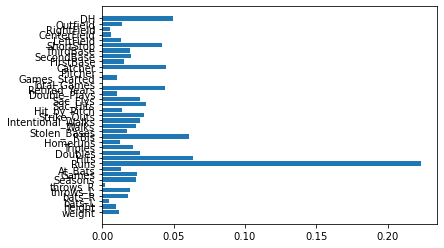

In [420]:
plt.barh(feature_names,XGmodel.feature_importances_)

In [421]:
# Run all data through the model to determine who should be in the hall of fame.
data_total = Position_Player_df.drop(['inducted', 
                                  'playerID', 
                                  'nameFirst', 
                                  'nameLast', 
                                  'finalGame', 
                                  'yearID',
                                  'Primary_Position',
                                  'Hall_Eligible'], axis=1)
data_total.fillna(0, inplace=True)
data_total=data_total.fillna(0)
data_total.head()

,weight,height,bats_L,bats_R,throws_L,throws_R,Seasons,Games,At_Bats,Runs,...,Catcher,FirstBase,SecondBase,ThirdBase,ShortStop,LeftField,CenterField,RightField,Outfield,DH
0,180.0,72.0,0,1,0,1,23,3298,12364,2174,...,0.0,0.063675,0.013038,0.002122,0.000000,0.095512,0.093390,0.659187,0.836871,0.060946
1,190.0,75.0,0,1,0,1,7,437,944,102,...,0.0,0.530892,0.016018,0.022883,0.000000,0.308924,0.002288,0.004577,0.313501,0.000000
2,184.0,73.0,1,0,1,0,3,15,21,1,...,0.0,0.533333,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000
3,192.0,72.0,0,1,0,1,3,12,49,4,...,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,170.0,71.0,0,1,0,1,11,855,3044,355,...,0.0,0.000000,0.490058,0.023392,0.453801,0.000000,0.002339,0.001170,0.003509,0.000000


In [422]:
data_total_scaler = StandardScaler().fit(data_total)
data_total_scaled = data_total_scaler.transform(data_total)
data_total_predicted = XGmodel.predict(data_total_scaled)

In [423]:
postions_predict_df = pd.concat([Position_Player_df, pd.Series(data_total_predicted)], axis=1)
postions_predict_df = postions_predict_df.rename(columns={0:'model_predict'})
postions_predict_df['Comparison']=postions_predict_df['inducted']==postions_predict_df['model_predict']
postions_predict_df.head()

,playerID,nameFirst,nameLast,weight,height,bats_L,bats_R,throws_L,throws_R,Seasons,...,ShortStop,LeftField,CenterField,RightField,Outfield,DH,Primary_Position,Hall_Eligible,model_predict,Comparison
0,aaronha01,Hank,Aaron,180.0,72.0,0,1,0,1,23,...,0.000000,0.095512,0.093390,0.659187,0.836871,0.060946,Outfield,1,1,True
1,aaronto01,Tommie,Aaron,190.0,75.0,0,1,0,1,7,...,0.000000,0.308924,0.002288,0.004577,0.313501,0.000000,FirstBase,0,0,True
2,abadan01,Andy,Abad,184.0,73.0,1,0,1,0,3,...,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000,FirstBase,0,0,True
3,abadijo01,John,Abadie,192.0,72.0,0,1,0,1,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,FirstBase,0,0,True
4,abbated01,Ed,Abbaticchio,170.0,71.0,0,1,0,1,11,...,0.453801,0.000000,0.002339,0.001170,0.003509,0.000000,SecondBase,1,0,True


In [424]:
from sklearn.neighbors import KNeighborsClassifier

In [425]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='euclidean')

In [426]:
y_pred = knn.predict(X_test_scaled)

In [427]:
from imblearn.over_sampling import ADASYN 

In [428]:
ada = ADASYN()
X_ada, y_ada = ada.fit_sample(X_train_scaled,y_train)

In [429]:
clf_ada = BalancedRandomForestClassifier(random_state=0)
clf_ada = clf.fit(X_ada, y_ada)
clf.score(X_test_scaled, y_test)

0.945054945054945

In [430]:
y_predicted_ada = clf_ada.predict(X_test_scaled)
# from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_predicted_ada))

predictions_df = pd.concat([pd.DataFrame(X_test_scaled),
#                            .copy().assign(
                           pd.DataFrame(dict(
    predicted= y_predicted_ada,
    actual=y_test
)).reset_index(drop=True)
                           ], axis=1)
# pd.Series(y_test).value_counts()#[:20]
actual_inductees = predictions_df.loc[predictions_df.actual==1]
predictions_for_actual_inductees = actual_inductees.predicted.value_counts()

[[568  30]
 [  5  34]]


<BarContainer object of 37 artists>

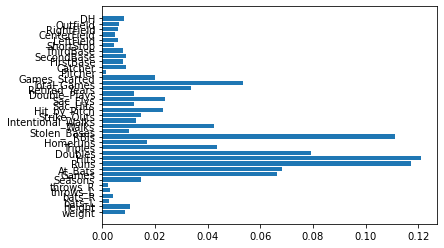

In [431]:
plt.barh(feature_names,clf_ada.feature_importances_)

In [432]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled,y_train)
x_GB = XGBClassifier(scale_pos_weight=1)
x_GB.fit(X_resampled, y_resampled)
y_GB = x_GB.predict(X_test_scaled)
print(len(X_resampled), len(y_resampled))

3580 3580


In [433]:
X_resampled_df = pd.DataFrame(X_resampled)
X_resampled_df.shape

(3580, 37)

In [434]:
y_GB.shape

(637,)

In [435]:
y_test.shape

(637,)

In [436]:
y_sample_check = pd.DataFrame(dict(predicted= y_GB,actual=y_test)).reset_index(drop=True)
y_sample_check.shape

(637, 2)

In [437]:
XGB_predictions_df = pd.concat([pd.DataFrame(X_test_scaled),
                           pd.DataFrame(dict(
    predicted= y_GB,
    actual=y_test)).reset_index(drop=True) ], axis=1)
actual_inductees = predictions_df.loc[predictions_df.actual==1]
predictions_for_actual_inductees = actual_inductees.predicted.value_counts()
print(classification_report(y_test,y_GB))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       598
           1       0.59      0.90      0.71        39

    accuracy                           0.96       637
   macro avg       0.79      0.93      0.85       637
weighted avg       0.97      0.96      0.96       637

